# Colab E(iii): TensorFlow Functional API

**Using `tf.keras.Input` and Functional Model Construction**

---

### Key Approach
- `tf.keras.Input` to declare input shape
- Chain `layers.Dense(...)()` calls functionally
- `tf.keras.Model(inputs, outputs)` to build model
- Custom GradientTape training loop

## Cell 1: Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

tf.random.set_seed(42)
np.random.seed(42)
print(f'TensorFlow: {tf.__version__}')

TensorFlow: 2.19.0


## Cell 2: Generate Data

In [2]:
num_samples = 2000
x1 = np.random.uniform(-2, 2, num_samples)
x2 = np.random.uniform(-2, 2, num_samples)
x3 = np.random.uniform(-2, 2, num_samples)
y_true = np.sin(x1) * x2**2 + np.cos(x3) * x1 + 0.5 * x3 * x2

X_np = np.column_stack([x1, x2, x3]).astype(np.float32)
Y_np = y_true.reshape(-1, 1).astype(np.float32)
X_mean, X_std = X_np.mean(0), X_np.std(0)
Y_mean, Y_std = Y_np.mean(), Y_np.std()
X_norm = ((X_np - X_mean) / X_std).astype(np.float32)
Y_norm = ((Y_np - Y_mean) / Y_std).astype(np.float32)

split = int(0.8 * num_samples)
train_ds = tf.data.Dataset.from_tensor_slices((X_norm[:split], Y_norm[:split])).shuffle(2000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((X_norm[split:], Y_norm[split:])).batch(64)
print(f'Data ready. Train: {split}, Test: {num_samples-split}')

Data ready. Train: 1600, Test: 400


## Cell 3: 4D Visualization

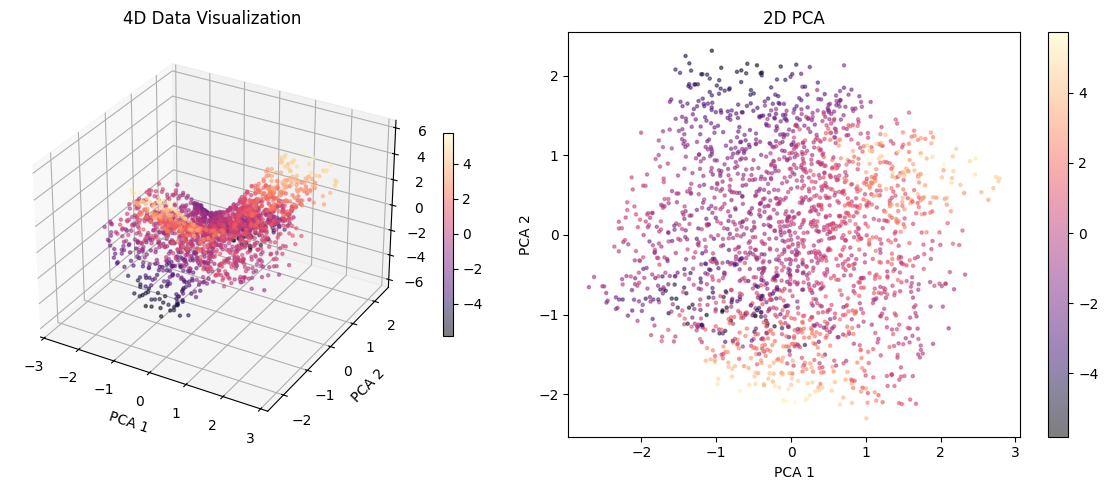

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], Y_np.flatten(), c=Y_np.flatten(), cmap='magma', s=5, alpha=0.5)
ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('y')
ax.set_title('4D Data Visualization')
plt.colorbar(sc, ax=ax, shrink=0.5)
ax2 = fig.add_subplot(122)
sc2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_np.flatten(), cmap='magma', s=5, alpha=0.5)
ax2.set_xlabel('PCA 1'); ax2.set_ylabel('PCA 2'); ax2.set_title('2D PCA')
plt.colorbar(sc2, ax=ax2)
plt.tight_layout(); plt.show()

## Cell 4: Build Model Using Functional API

The Functional API declares inputs via `keras.Input`, then chains layer calls functionally.
This creates a DAG (Directed Acyclic Graph) of layers — more flexible than Sequential.

In [4]:
# Functional API: declare input, chain layers, create Model
inputs = keras.Input(shape=(3,), name='input_features')

x = layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='hidden_1')(inputs)
x = layers.Dense(32, activation='relu', kernel_initializer='he_normal', name='hidden_2')(x)
x = layers.Dense(16, activation='relu', kernel_initializer='he_normal', name='hidden_3')(x)
outputs = layers.Dense(1, name='output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='functional_regression_dnn')
model.summary()

Model: "functional_regression_dnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_features (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

## Cell 5: Visualize Model Architecture

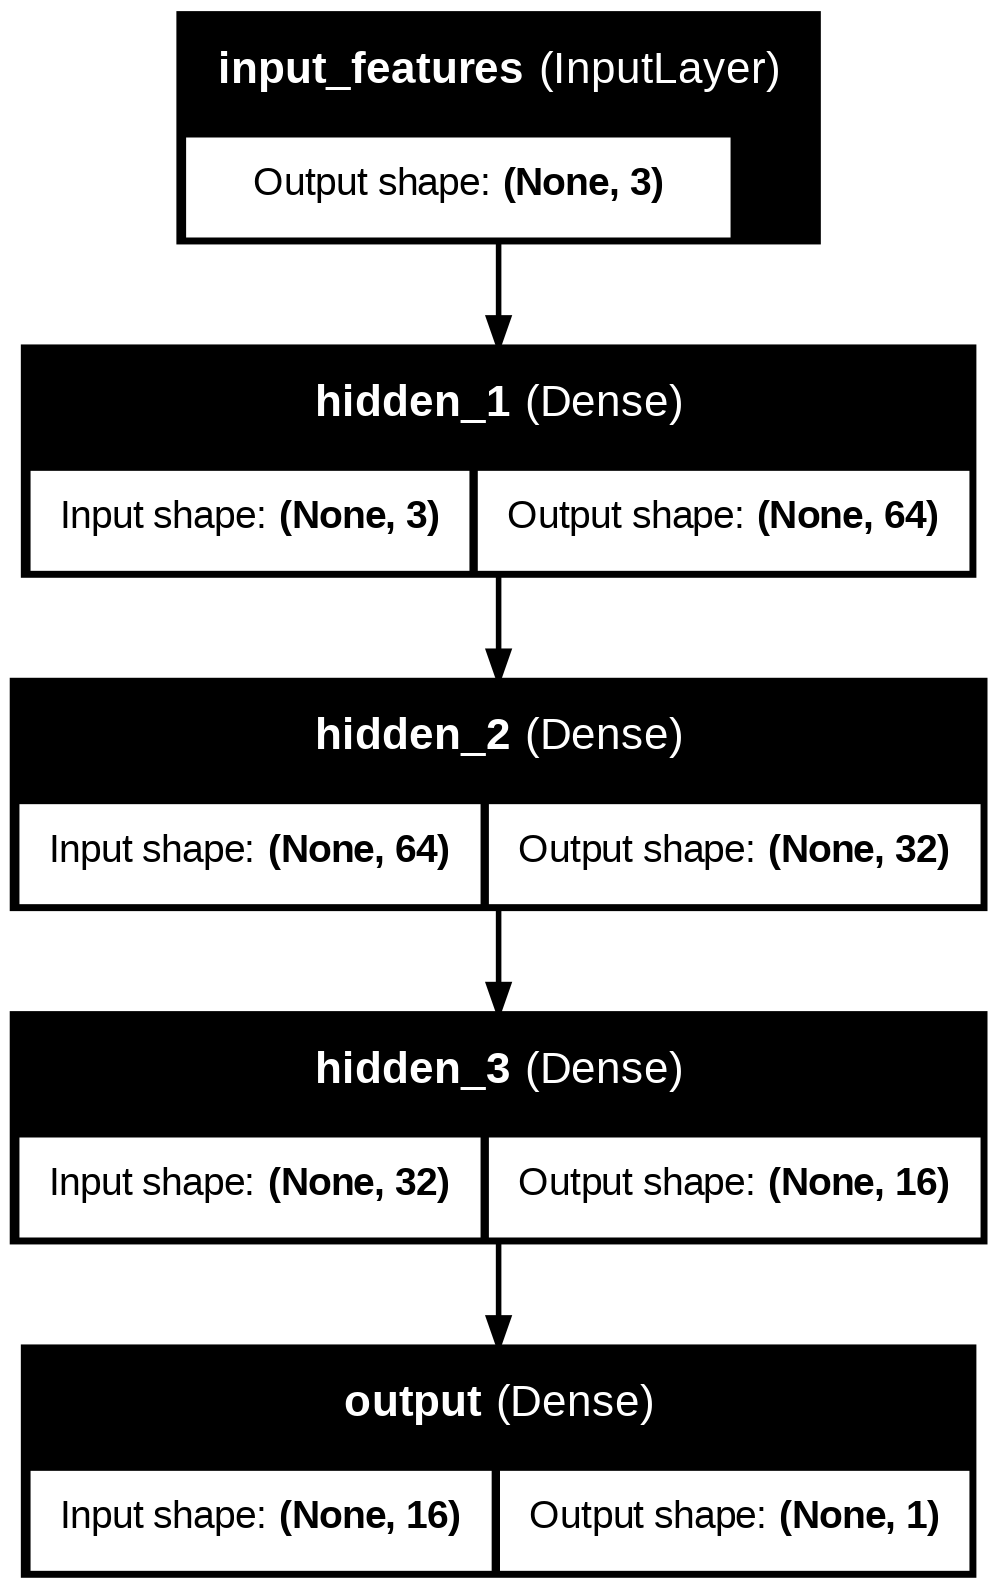

In [5]:
# Plot model architecture
try:
    keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
    from IPython.display import Image
    display(Image('model.png'))
except Exception as e:
    print(f'Model plot not available: {e}')
    print('Architecture: Input(3) -> Dense(64,ReLU) -> Dense(32,ReLU) -> Dense(16,ReLU) -> Dense(1)')

## Cell 6: Training with Custom GradientTape Loop

In [6]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.MeanSquaredError()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        preds = model(x, training=True)
        loss = loss_fn(y, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function
def test_step(x, y):
    return loss_fn(y, model(x, training=False))

epochs = 200
train_losses, test_losses = [], []

for epoch in range(epochs):
    tl, tn = 0.0, 0
    for xb, yb in train_ds:
        tl += train_step(xb, yb).numpy(); tn += 1
    vl, vn = 0.0, 0
    for xb, yb in test_ds:
        vl += test_step(xb, yb).numpy(); vn += 1
    train_losses.append(tl/tn); test_losses.append(vl/vn)
    if (epoch+1) % 20 == 0 or epoch == 0:
        print(f'Epoch {epoch+1:>3}/{epochs} | Train: {train_losses[-1]:.6f} | Test: {test_losses[-1]:.6f}')

print(f'\nFinal Train: {train_losses[-1]:.6f}, Test: {test_losses[-1]:.6f}')

Epoch   1/200 | Train: 0.506605 | Test: 0.175776
Epoch  20/200 | Train: 0.021388 | Test: 0.023233
Epoch  40/200 | Train: 0.011163 | Test: 0.014262
Epoch  60/200 | Train: 0.006016 | Test: 0.007752
Epoch  80/200 | Train: 0.004502 | Test: 0.004506
Epoch 100/200 | Train: 0.002702 | Test: 0.003762
Epoch 120/200 | Train: 0.002125 | Test: 0.003086
Epoch 140/200 | Train: 0.002113 | Test: 0.002691
Epoch 160/200 | Train: 0.001564 | Test: 0.002312
Epoch 180/200 | Train: 0.002642 | Test: 0.002445
Epoch 200/200 | Train: 0.001644 | Test: 0.002602

Final Train: 0.001644, Test: 0.002602


## Cell 7: Loss Curves

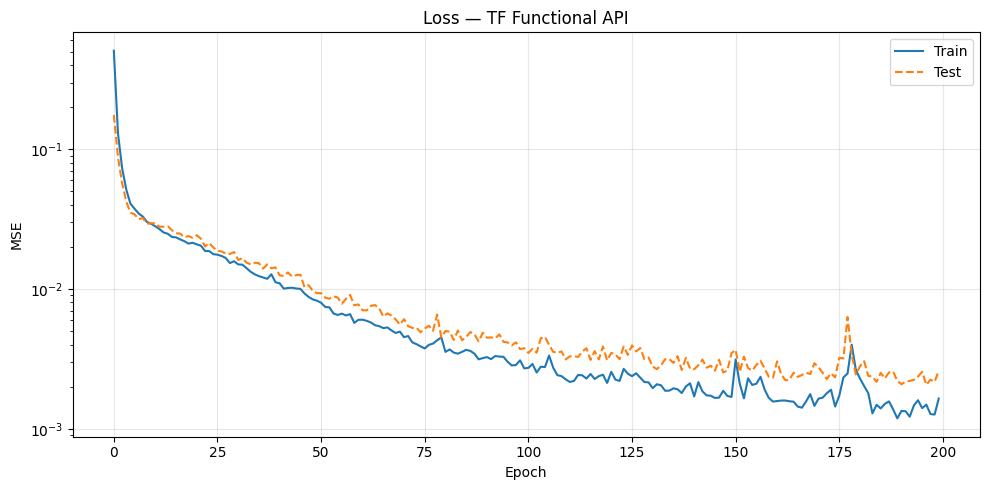

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train', lw=1.5)
plt.plot(test_losses, label='Test', lw=1.5, ls='--')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.title('Loss — TF Functional API')
plt.legend(); plt.grid(True, alpha=0.3); plt.yscale('log')
plt.tight_layout(); plt.show()

## Cell 8: Final Results

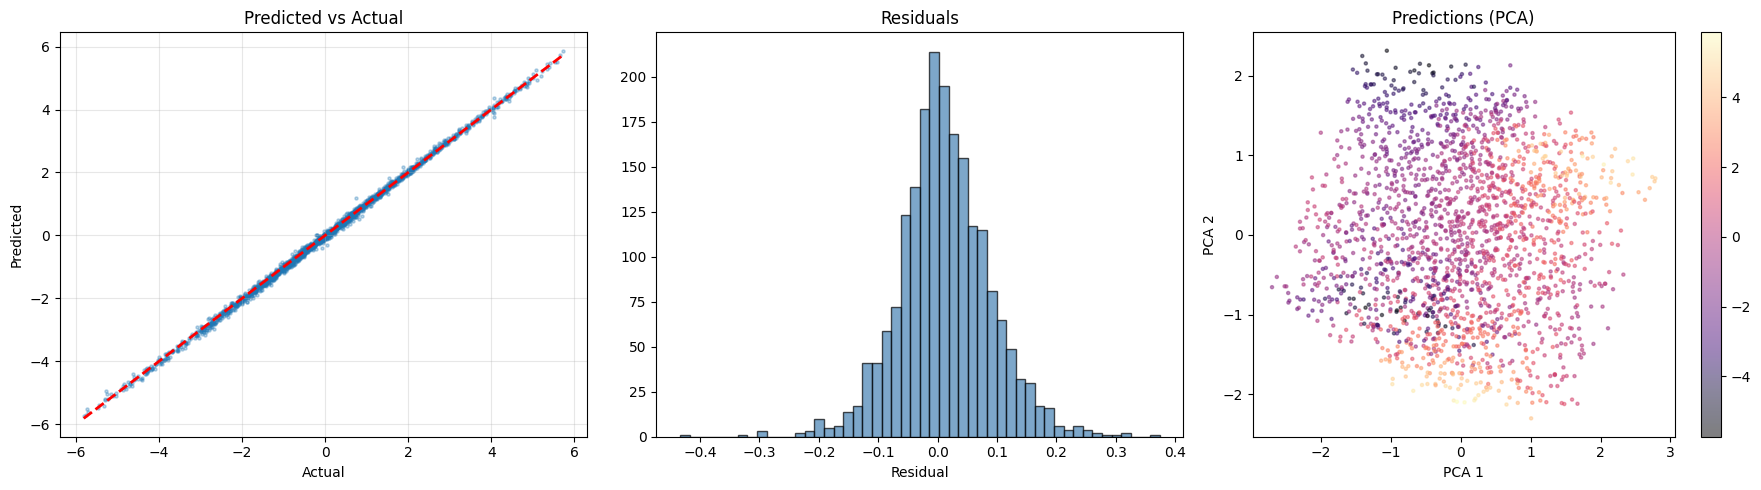

R-squared: 0.9984 | MAE: 0.0589


In [8]:
Y_pred = model.predict(X_norm, verbose=0)
Y_pred_d = Y_pred * Y_std + Y_mean
res = Y_np.flatten() - Y_pred_d.flatten()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].scatter(Y_np.flatten(), Y_pred_d.flatten(), alpha=0.3, s=5)
axes[0].plot([Y_np.min(), Y_np.max()], [Y_np.min(), Y_np.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual'); axes[0].set_ylabel('Predicted')
axes[0].set_title('Predicted vs Actual'); axes[0].grid(True, alpha=0.3)

axes[1].hist(res, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Residual'); axes[1].set_title('Residuals')

sc = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=Y_pred_d.flatten(), cmap='magma', s=5, alpha=0.5)
axes[2].set_xlabel('PCA 1'); axes[2].set_ylabel('PCA 2')
axes[2].set_title('Predictions (PCA)')
plt.colorbar(sc, ax=axes[2])
plt.tight_layout(); plt.show()

r2 = 1 - np.sum(res**2) / np.sum((Y_np.flatten() - Y_np.mean())**2)
print(f'R-squared: {r2:.4f} | MAE: {np.mean(np.abs(res)):.4f}')

## Cell 9: Summary

In [9]:
print('='*60)
print('Colab E(iii): TF Functional API — Complete!')
print('='*60)
print('Uses: keras.Input, layers.Dense chaining, keras.Model(inputs, outputs)')
print('Functional API advantages:')
print('  - Clear DAG visualization')
print('  - Model introspection (plot_model, summary)')
print('  - Multi-input/output support')
print(f'R-squared: {r2:.4f}')
print('='*60)

Colab E(iii): TF Functional API — Complete!
Uses: keras.Input, layers.Dense chaining, keras.Model(inputs, outputs)
Functional API advantages:
  - Clear DAG visualization
  - Model introspection (plot_model, summary)
  - Multi-input/output support
R-squared: 0.9984
